# Simple RAG with LangGraph

![Simple RAG](../../images/simple_rag.png)

In this notebook, we're going to set up a simple RAG application in LangGraph that we'll be using as we learn more about LangSmith.

RAG (Retrieval Augmented Generation) is a popular technique for providing LLMs with relevant documents that will enable them to better answer questions from users. 

In our case, we are going to index some LangSmith documentation!

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

#### Execute the Cell Below to setup our RAG application

/Users/nickhuang/Desktop/langsmith-academy/ls-academy/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
USER_AGENT environment variable not set, consider setting it to identify your requests.
Fetching pages: 100%|##########| 254/254 [00:42<00:00,  5.94it/s]


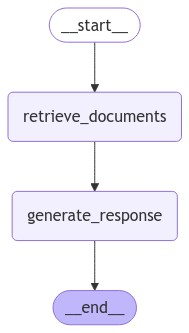

In [1]:
import nest_asyncio
import operator
from dotenv import load_dotenv
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

This should take a little less than a minute. We are indexing and storing LangSmith documentation in a local memory ChromaDB.

We're also setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

#### Setting up Tracing with LangChain or LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

In [ ]:
# You can set them inline!
import os

os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langsmith-academy"  # If you don't set this, traces will go to the Default project

In [4]:
# I have my env variables defined in a .env file
load_dotenv(dotenv_path="../../.env", override=True)

True

#### Let's try running our RAG application

In [6]:
question = "How do I set up tracing if I'm using LangChain?"
simple_rag_graph.invoke({"question": question})

{'question': "How do I set up tracing if I'm using LangChain?",
 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='To set up tracing in LangChain, ensure that the LANGCHAIN_TRACING_V2 environment variable is set to \'true\' and that you have the LANGCHAIN_API_KEY environment variable configured with your API key. This allows traces to be logged to LangSmith, with the default project being named "default." You can also log traces to a different project if needed.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 451, 'total_tokens': 524, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'fini

#### Let's take a look at our trace in LangSmith!